# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.index.is_monotonic

True

In [4]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Analysis

/tmp/ipykernel_49/2407059017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day['rolling_mean'] = df_day.rolling(7).mean()


<AxesSubplot:xlabel='datetime'>

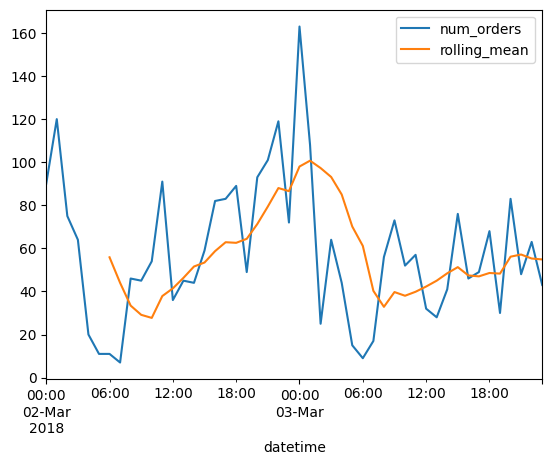

In [5]:
df_day = df['2018-03-02':'2018-03-03']
df_day['rolling_mean'] = df_day.rolling(7).mean()
df_day.plot()

/tmp/ipykernel_49/1148387578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week['rolling_mean'] = df_week.rolling(7).mean()


<AxesSubplot:xlabel='datetime'>

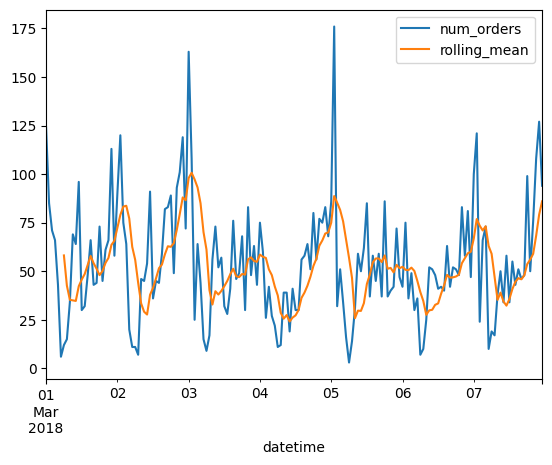

In [6]:
df_week = df['2018-03-01':'2018-03-07']
df_week['rolling_mean'] = df_week.rolling(7).mean()
df_week.plot()

March 1st 2018 was a thursday meaning there are spikes in activity on friday and sunday nights and steep drops after midnight

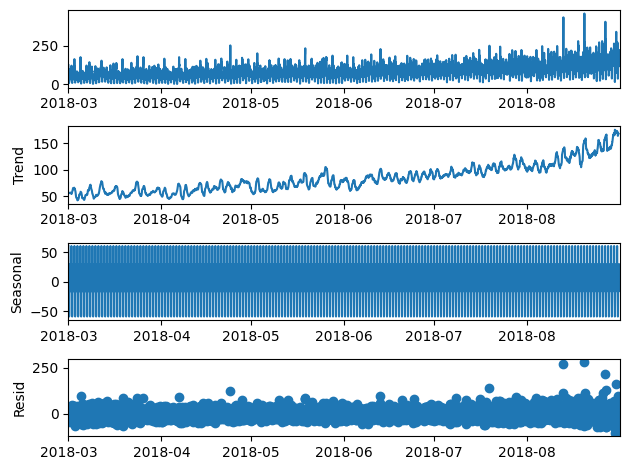

In [7]:
decomposition = seasonal_decompose(df)
decomposition.plot()
plt.show()

The trend shows an overall increase in demand for taxis overtime. There seems to be repetitive seasonal patterns however the graph is too zoomed out to get exact details. Residuals show a small amount of outliers but not enough to cause concern.

## Training

In [8]:
#lag features
df['lag_1'] = df['num_orders'].shift(1)
df['lag_2'] = df['num_orders'].shift(2)
df['lag_3'] = df['num_orders'].shift(3)
#moving avg features
shifted = df['num_orders'].shift(1)
df['ma_3'] = shifted.rolling(window=3).mean()
df['ma_5'] = shifted.rolling(window=5).mean()
df.dropna(inplace=True)
#splitting training and test set
train_valid, test = train_test_split(df, test_size=0.1, shuffle=False)
train, valid = train_test_split(train_valid, test_size=0.2, shuffle=False)
#add time series features
for df in [train, valid, test, train_valid]:
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month

/tmp/ipykernel_49/568636214.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
/tmp/ipykernel_49/568636214.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/tmp/ipykernel_49/568636214.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [9]:
features = ['hour', 'dayofweek', 'month', 'lag_1', 'lag_2', 'lag_3', 'ma_3', 'ma_5']
#hypertune RandomForest model
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30]}
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=tscv, scoring='neg_root_mean_squared_error')
grid_search.fit(train[features], train['num_orders'])

best_params_rf = grid_search.best_params_
display(best_params_rf)

#training with best params
best_rf_model = grid_search.best_estimator_
valid_predictions = best_rf_model.predict(valid[features])
valid_rmse = np.sqrt(mean_squared_error(valid['num_orders'], valid_predictions))

print(f'Validation RMSE: {valid_rmse}')

{'max_depth': 20, 'n_estimators': 200}

Validation RMSE: 31.993567975491022


<div class="alert alert-danger">
<b>Reviewer's comment</b>

The main metric of this project is RMSE. So, you should use RMSE instead of R2 in GridSearchCV.

</div>

In [10]:
#linear regression
param_grid = {'copy_X': [True,False], 'fit_intercept': [True,False], 
               'n_jobs': [1,5,10,15,None], 'positive': [True,False]}
grid_search = GridSearchCV(LinearRegression(), param_grid, cv=tscv, scoring='neg_root_mean_squared_error')
grid_search.fit(train[features], train['num_orders'])
best_params_lr = grid_search.best_params_
display(best_params_lr)

#training with best params
best_lr_model = grid_search.best_estimator_
valid_predictions = best_lr_model.predict(valid[features])
valid_rmse = np.sqrt(mean_squared_error(valid['num_orders'], valid_predictions))
print(f'Validation RMSE: {valid_rmse}')

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'positive': True}

Validation RMSE: 39.308979974540456


In [11]:
#ARIMA model
# Define possible values
p = d = q = range(0, 3)

# Create combinations
combinations = list(itertools.product(p, d, q))

best_rmse = float('inf')
best_params = None

for (p, d, q) in combinations:
    try:
        model = ARIMA(train['num_orders'], order=(p, d, q))
        model_fit = model.fit()
        
        # Forecast for validation set length
        predictions = model_fit.forecast(steps=len(valid))
        
        rmse = np.sqrt(mean_squared_error(valid['num_orders'], predictions))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (p, d, q)
    except Exception as e:
        # Print the exception message for better debugging
        print(f"Exception for parameters ({p}, {d}, {q}): {e}")
        continue

print(f'Best ARIMA RMSE: {best_rmse} with params: {best_params}')

Best ARIMA RMSE: 42.091436093684074 with params: (1, 2, 1)


In [12]:
#tuning sarima model
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 24

# Generate parameter combinations
combinations = list(itertools.product(p, d, q, P, D, Q))

best_rmse = float('inf')
best_params = None

for (p, d, q, P, D, Q) in combinations:
    try:
        # Fit SARIMA model
        sarima_model = SARIMAX(train['num_orders'], order=(p, d, q), seasonal_order=(P, D, Q, s))
        sarima_model_fit = sarima_model.fit(disp=False)
        
        # Forecast and calculate RMSE
        sarima_predictions = sarima_model_fit.forecast(steps=len(valid))
        rmse = np.sqrt(mean_squared_error(valid['num_orders'], sarima_predictions))
        
        # Update best parameters if RMSE is improved
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (p, d, q, P, D, Q)
    except Exception as e:
        print(f"Exception for parameters ({p}, {d}, {q}, {P}, {D}, {Q}): {e}")
        continue

print(f'Best SARIMA RMSE: {best_rmse} with params: {best_params}')

Best SARIMA RMSE: 32.79444610332626 with params: (1, 0, 1, 1, 1, 0)


The best performing model was the RandomForest with 31 RMSE. The SARIMA model showed potential but fell slightly short of the RandomForest in the initial training. 

## Testing

In [13]:
#Testing RF model
test_predictions = best_rf_model.predict(test[features])
test_rmse = np.sqrt(mean_squared_error(test['num_orders'], test_predictions))
   
print(f'Test RF RMSE: {test_rmse}')

Test RF RMSE: 59.99130301563628


In [14]:
#retraining best model on Train+valid set
rf_model = RandomForestRegressor(max_depth=20, n_estimators=200, random_state=12345)
rf_model.fit(train_valid[features], train_valid['num_orders'])
#testing on test set
test_pred = rf_model.predict(test[features])
test_rmse = np.sqrt(mean_squared_error(test['num_orders'], test_pred))
test_rmse

47.76389633881529

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48